Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from typing import Tuple
from collections import defaultdict
from random import choice
from tqdm import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np

class TrainTask:

    def __init__(self, lr=0.01, df=0.01, p=0.01, n_sim=1, num_matches=1000000, test_freq=100000, test_matches=1000, test_agent='random') -> None:
        """
        Set parameters for the task
        """
        self.policy = defaultdict(lambda: defaultdict(lambda: np.random.uniform(low=-1, high=1)))
        self.lr = lr # Learning rate
        self.df = df # Discount factor
        self.p = p # Probavility to select a random move
        self.num_matches = num_matches
        self.test_freq = test_freq
        self.test_matches = test_matches
        self.test_agent = test_agent
        self.n_sim = n_sim
        self.best_policy_score = 0
        self.best_policy = deepcopy(self.policy)
        self.metrics = [[[],[],[]],[[],[],[]]] # Stores win, draws, losses for trained agent startinng first or second 
    
    def test(self) -> None:
        test_dict = defaultdict(int)
        test_dict_second_start = defaultdict(int)
        for _ in range(self.test_matches):
            outcome=self.play_match(train=False)
            test_dict[outcome] += 1
            outcome=self.play_match(train=False, starting='expert')
            test_dict_second_start[outcome] += 1
        for i in range(3):
            self.metrics[0][i].append(test_dict[i])
            self.metrics[1][i].append(test_dict_second_start[i])
    
    def display_stats(self) -> None:
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax1.plot(self.metrics[0][0], label='Wins', color='g')
        ax1.axhline(y=max(self.metrics[0][0]), color='g', linestyle='--', label='Maximum wins')
        ax1.text(1, max(self.metrics[0][0])+0.1, f'{max(self.metrics[0][0])}')
        ax1.plot(self.metrics[0][1], label='Draws', color='y')
        ax1.plot(self.metrics[0][2], label='Losses', color='r')
        ax1.set_title('Outcomes as trained agent starts first')
        ax1.legend()
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Count')

        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)
        ax2.plot(self.metrics[1][0], label='Wins', color='g')
        ax2.axhline(y=max(self.metrics[1][0]), color='g', linestyle='--', label='Maximum wins')
        ax2.text(1, max(self.metrics[1][0])+0.1, f'{max(self.metrics[1][0])}')
        ax2.plot(self.metrics[1][1], label='Draws', color='y')
        ax2.plot(self.metrics[1][2], label='Losses', color='r')
        ax2.set_title('Outcomes as trained agent starts second')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Count')
        ax2.legend()

    def train(self) -> None:
        """
        Execute training
        """
        for i in tqdm(range(self.num_matches)):
            self.play_match()
            if i%self.test_freq==0:
                self.test()
        self.display_stats()

    def update_policy(self, state, action) -> None:
        optimal_estimate = 0 if len(self.policy[action].values())==0 else max(self.policy[action].values())
        self.policy[state][action] = (1-self.lr)*self.policy[state][action]+\
            self.lr*(self.compute_reward(state, action)+self.df*optimal_estimate)
    
    def is_terminal(self, state) -> bool:
        """
        Checks if state is terminal
        """
        for i in range(3):
            if state[i * 3] == state[i * 3 + 1] == state[i * 3 + 2] and state[i * 3] != 2:
                return True
            if state[i] == state[i + 3] == state[i + 6] and state[i] != 2:
                return True
    
        if state[0] == state[4] == state[8] and state[0] != 2:
            return True
        if state[2] == state[4] == state[6] and state[2] != 2:
            return True
        
        return False
    
    def player_has_won(self, state, player) -> bool:
        
        for i in range(3):
            if sum([state[i * 3 + j]==player for j in range(3)]) > 2:
                return True
            if sum([state[i + 3 * j]==player for j in range(3)]) > 2:
                return True

        if sum([state[4*j]==player for j in range(3)]) > 2:
            return True
        
        if sum([state[2+2*j]==player for j in range(3)]) > 2:
            return True
        
        return False

    def compute_reward(self, state, action) -> float:
        
        if self.player_has_won(action, 0):
            # if wins, return 1 reward
            return 1
        
        move_idx = np.argmax(np.array(state)-np.array(action))

        straight_lines_indeces = []
        straight_lines_indeces += [[0,1,2],[3,4,5],[6,7,8]]
        straight_lines_indeces += [[0,3,6],[1,4,7],[2,5,8]]
        straight_lines_indeces += [[0,4,8],[2,4,6]]

        straight_lines_occupied = 0

        n_opponent_winning_moves = 0
        prevented_opponent_from_winning = False
        
        for player in [0,1]:
            # Check if missed win or if blocked opponent chance of winning
            # Otherwise reward moves that occupy the greatest number of straight lines
            for line in straight_lines_indeces:

                if sum([state[i]==player for i in line])==2:
                    # If straight line has two marks of the same player
                    if player==0:
                        # If player is current agent penalise because it did not win
                        return -1
                    else:
                        # If player is opponent
                        if not move_idx in line:
                            n_opponent_winning_moves += 1
                            # Take note that player did not prevent opponent from winning
                        else:
                            prevented_opponent_from_winning = True
                            # Take note that player prevented opponent from winning
                        
                if move_idx in line:
                    # Reward moves that occupy a large numer of straight lines
                    straight_lines_occupied += 1
        
        if n_opponent_winning_moves > 0:
            return -1
        
        if prevented_opponent_from_winning:
            return 1
        
        return straight_lines_occupied/len(straight_lines_indeces)

    def flip_state(self, state):
        """
        Flips the state to change turn
        """
        new_state = []
        for bit in state:
            if bit!=2:
                new_state.append(1-bit)
            else:
                new_state.append(bit)
        return tuple(new_state)

    def choose_action(self, state, train=True) -> Tuple:
        action_dict = self.policy[state]
        
        if not train:
            if len(action_dict) > 0:
                action = max(action_dict.items(), key=lambda x: x[1])[0] # Naive approach, returns always the action with the best expected Q
            else:
                action = self.random_move(state)
        else:
            if np.random.uniform() < self.p:
                action = self.random_move(state)
            else:
                if len(action_dict) > 0:
                    action = max(action_dict.items(), key=lambda x: x[1])[0] # Naive approach, returns always the action with the best expected Q
                else:
                    action = self.random_move(state)
        return action
    
    def random_move(self, state) -> Tuple:
        action = np.array(state)
        pos_vector = np.array(list(range(9)))
        action[choice(pos_vector[action==2])] = 0
        return tuple(action)


    def play_match(self, train=True, starting='player') -> int:
        """
        Plays one match
        """
        state = tuple(np.ones((9,))*2)
        terminal = False
        move = 0
        if starting=='player':
            curr_player = 1
        else:
            curr_player = 0
        while not terminal and move<9:
            curr_player = 1 - curr_player
            state = self.flip_state(state)
            if train or curr_player==0:
                action = self.choose_action(state, train)
            else:
                if self.test_agent == 'random':
                    action = self.random_move(state)
            if train:
                self.update_policy(state, action)
            state = action
            terminal = self.is_terminal(state)
            move+=1
        if move == 9:
            return 2
        else:
            return curr_player

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:36<00:00, 815.15it/s]


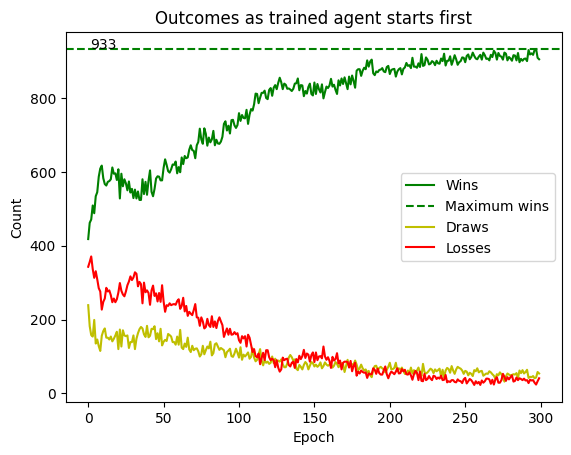

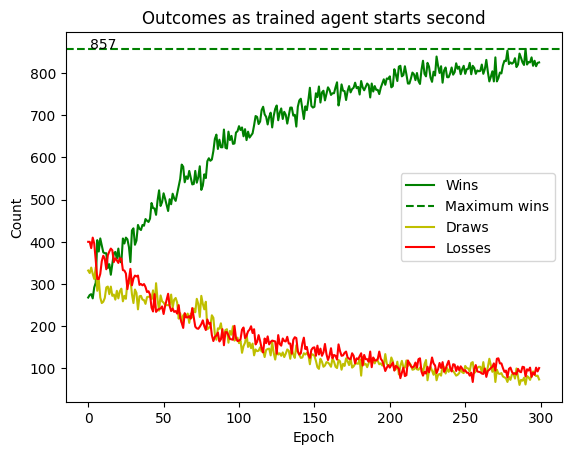

In [2]:
task = TrainTask(num_matches=int(3e4), test_freq=int(1e2), df=0.9, lr=0.1, p=0.99)
task.train()